***DATA PREPROCESSING***

***1. Importing libraries and loading data***

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/formula-1-world-championship-1950-2020/races.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv
/kaggle/input/formula-1-world-championship-1950-2020/lap_times.csv
/kaggle/input/formula-1-world-championship-1950-2020/status.csv
/kaggle/input/formula-1-world-championship-1950-2020/driver_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/seasons.csv
/kaggle/input/formula-1-world-championship-1950-2020/pit_stops.csv
/kaggle/input/formula-1-world-championship-1950-2020/sprint_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/results.csv
/kaggle/input/formula-1-world-championship-1950-2020/circuits.csv
/kaggle/input/formula-1-world-championship-1950-2020/qualifying.csv


In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# loading the dataset
df = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/lap_times.csv')

#displaying basic info
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589081 entries, 0 to 589080
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   raceId        589081 non-null  int64 
 1   driverId      589081 non-null  int64 
 2   lap           589081 non-null  int64 
 3   position      589081 non-null  int64 
 4   time          589081 non-null  object
 5   milliseconds  589081 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 27.0+ MB


,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


***2. Understanding Data***

In [3]:
# Display first 10 rows
df.head(10)

# Quick summary statistics for numeric columns
df.describe()

,raceId,driverId,lap,position,milliseconds
count,589081.000000,589081.000000,589081.000000,589081.000000,5.890810e+05
mean,600.544465,325.796446,30.018104,9.661951,9.579945e+04
std,434.375976,387.561736,18.407126,5.528553,7.639973e+04
min,1.000000,1.000000,1.000000,1.000000,5.540400e+04
25%,140.000000,16.000000,14.000000,5.000000,8.204100e+04
50%,861.000000,48.000000,29.000000,9.000000,9.060800e+04
75%,1003.000000,822.000000,44.000000,14.000000,1.019300e+05
max,1144.000000,862.000000,87.000000,24.000000,7.507547e+06


***2.1. Checking DataTypes and Unique Values***

In [4]:
results = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/results.csv')

print(results['position'].dtype)
print(results['position'].unique()[:20])  # show first 20 unique values


object
['1' '2' '3' '4' '5' '6' '7' '8' '\\N' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19']


***3. Converting DataTypes to Numeric Only and Setting Non-Numeric as NaN***

In [5]:
# Convert position to numeric, turn non-numeric to NaN
results['position'] = pd.to_numeric(results['position'], errors='coerce')

***4. Dropping Nan i.e. Non-Numeric***

In [6]:
results = results.dropna(subset=['position'])

***5. Create Podium Target***

In [7]:
# Binary target for podium finish
results['podium'] = results['position'].apply(lambda x: 1 if x <=3 else 0)
results['podium'].value_counts()


podium
0    12410
1     3396
Name: count, dtype: int64

***4. Choosing Potential Features***

In [8]:
# Columns I want to test
cols = ['grid', 'laps', 'constructorId', 'driverId', 'statusId']

summary = []

for col in cols:
    is_unique = results[col].is_unique
    nunique = results[col].nunique()
    total = len(results[col])
    
    # Heuristic: if unique values = number of rows ⇒ it's an ID column
    should_drop = is_unique or (nunique == total)
    
    summary.append({
        "Column": col,
        "Is Unique": is_unique,
        "Unique Count": nunique,
        "Total Rows": total,
        "Should Drop?": should_drop
    })

pd.DataFrame(summary)


,Column,Is Unique,Unique Count,Total Rows,Should Drop?
0,grid,False,34,15806,False
1,laps,False,139,15806,False
2,constructorId,False,162,15806,False
3,driverId,False,659,15806,False
4,statusId,False,89,15806,False


In [9]:
features = ['grid', 'laps', 'constructorId', 'driverId', 'statusId']
X = results[features]
y_position = results['position']      # numeric target
y_podium = results['podium']          # binary target


***5. Preprocessing Features***

Numerical features → scale (Standardization)

Categorical features → encode (OneHotEncoding)

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_features = ['grid', 'laps']
cat_features = ['constructorId', 'driverId', 'statusId']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)


***TRAINING AND TESTING***

Since we have two targets, we’ll make two pipelines:

SVM Regression → predict position (numeric)

SVM Classification → predict podium (binary top 3)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report

# Split data into train and test sets
X_train, X_test, y_train_position, y_test_position = train_test_split(
    X, y_position, test_size=0.2, random_state=42
)
_, _, y_train_podium, y_test_podium = train_test_split(
    X, y_podium, test_size=0.2, random_state=42
)

# SVM Regression pipeline
svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR(kernel='rbf'))  # RBF kernel
])

svr_pipeline.fit(X_train, y_train_position)
y_pred_position = svr_pipeline.predict(X_test)

print("SVM Regression Metrics:")
print("MAE:", mean_absolute_error(y_test_position, y_pred_position))
print("MSE:", mean_squared_error(y_test_position, y_pred_position))
print("RMSE:", mean_squared_error(y_test_position, y_pred_position, squared=False))

# SVM Classification pipeline
svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC(kernel='rbf'))
])

svc_pipeline.fit(X_train, y_train_podium)
y_pred_podium = svc_pipeline.predict(X_test)

print("\nSVM Classification Metrics:")
print("Accuracy:", accuracy_score(y_test_podium, y_pred_podium))
print(classification_report(y_test_podium, y_pred_podium))


SVM Regression Metrics:
MAE: 1.9259395522751463
MSE: 6.727523163713617
RMSE: 2.5937469351718985

SVM Classification Metrics:
Accuracy: 0.8902593295382669
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2460
           1       0.77      0.71      0.74       702

    accuracy                           0.89      3162
   macro avg       0.85      0.83      0.84      3162
weighted avg       0.89      0.89      0.89      3162



***Visualizing Regression (Final Position)***

***Scatter Plot Visualization***

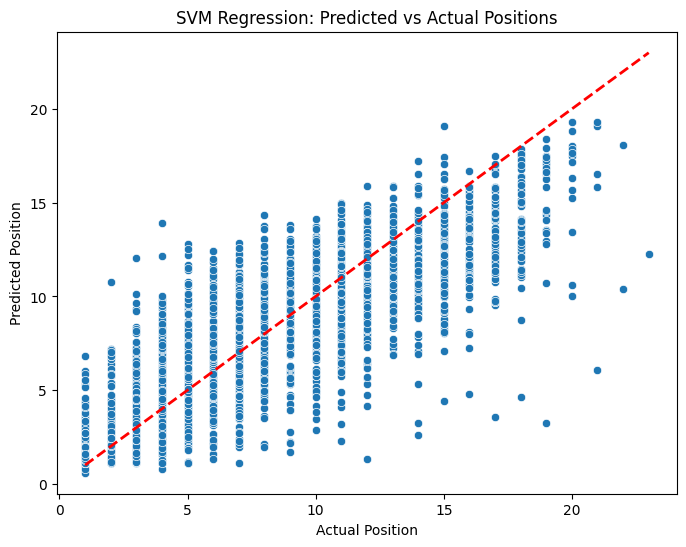

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_position, y=y_pred_position)
plt.xlabel('Actual Position')
plt.ylabel('Predicted Position')
plt.title('SVM Regression: Predicted vs Actual Positions')
plt.plot([y_test_position.min(), y_test_position.max()],
         [y_test_position.min(), y_test_position.max()],
         'r--', lw=2)  # perfect prediction line
plt.show()
